In [1]:
import requests
import pandas as pd
import tqdm
import bs4
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text
from pathlib import Path
import time

In [2]:
from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs

In [ ]:
reverse_type_map = {1: 'Jump Shot',
 79: 'Pullup Jump shot',
 52: 'Alley Oop Dunk Shot',
 3: 'Hook Shot',
 80: 'Step Back Jump shot',
 47: 'Turnaround Jump Shot',
 5: 'Layup Shot',
 103: 'Running Pull-Up Jump Shot',
 6: 'Driving Layup Shot',
 50: 'Running Dunk Shot',
 108: 'Cutting Dunk Shot',
 43: 'Alley Oop Layup shot',
 101: 'Driving Floating Jump Shot',
 2: 'Running Jump Shot',
 86: 'Turnaround Fadeaway shot',
 63: 'Fadeaway Jump Shot',
 78: 'Floating Jump shot',
 98: 'Cutting Layup Shot',
 41: 'Running Layup Shot',
 7: 'Dunk Shot',
 9: 'Driving Dunk Shot',
 99: 'Cutting Finger Roll Layup Shot',
 76: 'Running Finger Roll Layup Shot',
 58: 'Turnaround Hook Shot',
 106: 'Running Alley Oop Dunk Shot',
 102: 'Driving Floating Bank Jump Shot',
 100: 'Running Alley Oop Layup Shot',
 73: 'Driving Reverse Layup Shot',
 105: 'Turnaround Fadeaway Bank Jump Shot',
 75: 'Driving Finger Roll Layup Shot',
 44: 'Reverse Layup Shot',
 74: 'Running Reverse Layup Shot',
 66: 'Jump Bank Shot',
 57: 'Driving Hook Shot',
 67: 'Hook Bank Shot',
 71: 'Finger Roll Layup Shot',
 93: 'Driving Bank Hook Shot',
 51: 'Reverse Dunk Shot',
 110: 'Running Reverse Dunk Shot',
 104: 'Step Back Bank Jump Shot',
 109: 'Driving Reverse Dunk Shot',
 96: 'Turnaround Bank Hook Shot',
 8: 'Slam Dunk Shot',
 42: 'Driving Layup Shot',
 4: 'Tip Shot',
 65: 'Jump Hook Shot',
 46: 'Running Jump Shot',
 49: 'Driving Dunk Shot',
 56: 'Running Hook Shot',
 64: 'Follow Up Dunk Shot',
 59: 'Finger Roll Shot',
 61: 'Driving Finger Roll Shot',
 60: 'Running Finger Roll Shot',
 62: 'Turnaround Finger Roll Shot',
 54: 'Running Tip Shot',
 53: 'Tip Shot',
 45: 'Jump Shot',
 40: 'Layup Shot',
 48: 'Dunk Shot',
 55: 'Hook Shot',
 85: 'Turnaround Bank shot',
 87: 'Putback Dunk Shot',
 77: 'Driving Jump shot',
 72: 'Putback Layup Shot',
 90: 'Running Slam Dunk Shot',
 88: 'Driving Slam Dunk Shot',
 92: 'Putback Slam Dunk Shot',
 83: 'Fadeaway Bank shot',
 95: 'Running Bank Hook Shot',
 84: 'Running Bank shot',
 89: 'Reverse Slam Dunk Shot',
 82: 'Driving Bank shot',
 81: 'Pullup Bank shot',
 91: 'Putback Reverse Dunk Shot',
 94: 'Jump Bank Hook Shot',
                   }

In [3]:
full_df = pd.read_csv('pbp_data/2021-22.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [6]:
shots_made = full_df.loc[full_df.EVENTMSGTYPE == 1]

In [28]:
assists = shots_made.loc[shots_made.PLAYER2_ID != 0]

In [18]:
assist_counts = assists.groupby(['PLAYER1_NAME', 'PLAYER2_NAME']).size().to_frame().reset_index()

In [19]:
assist_counts = assist_counts.rename(columns={0: 'COUNT'})

In [25]:
alley_oop_types = [43, 52, 106, 100]

In [34]:
alley_oops = assists.loc[assists.EVENTMSGACTIONTYPE.isin(alley_oop_types)]

In [41]:
oop_counts = alley_oops.groupby(['PLAYER1_NAME', 'PLAYER1_ID', 'PLAYER2_NAME', 'PLAYER2_ID']).size().to_frame().reset_index().rename(columns={0: 'COUNT'})

In [42]:
top_alley_oopers = oop_counts.sort_values(by='COUNT', ascending=False).iloc[:15]

In [43]:
top_alley_oopers

,PLAYER1_NAME,PLAYER1_ID,PLAYER2_NAME,PLAYER2_ID,COUNT
71,Clint Capela,203991,Trae Young,1629027,23
323,Rudy Gobert,203497,Mike Conley,201144,21
26,Anthony Davis,203076,Russell Westbrook,201566,17
182,Jarrett Allen,1628386,Darius Garland,1629636,16
318,Robert Williams III,1629057,Marcus Smart,203935,14
208,John Collins,1628381,Trae Young,1629027,13
313,Richaun Holmes,1626158,Tyrese Haliburton,1630169,11
94,Deandre Ayton,1629028,Chris Paul,101108,11
69,Clint Capela,203991,John Collins,1628381,10
80,Daniel Gafford,1629655,Spencer Dinwiddie,203915,10


In [72]:
oop_assisters = alley_oops.groupby('PLAYER2_NAME').size().to_frame().reset_index().rename(columns={0: 'COUNT'})

In [73]:
oop_assisters.sort_values(by='COUNT', ascending=False)

,PLAYER2_NAME,COUNT
180,Trae Young,40
162,Russell Westbrook,30
41,Darius Garland,28
128,Luka Doncic,27
138,Mike Conley,21
184,Tyrese Haliburton,18
134,Marcus Smart,18
85,James Harden,17
121,LaMelo Ball,17
120,Kyle Lowry,17


## Plotting alley ooper table

In [63]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.63
team_root_dir = '../../team_logos_id/'
player_root_dir = f'player_imgs/'

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [64]:
plt.style.use('fivethirtyeight')

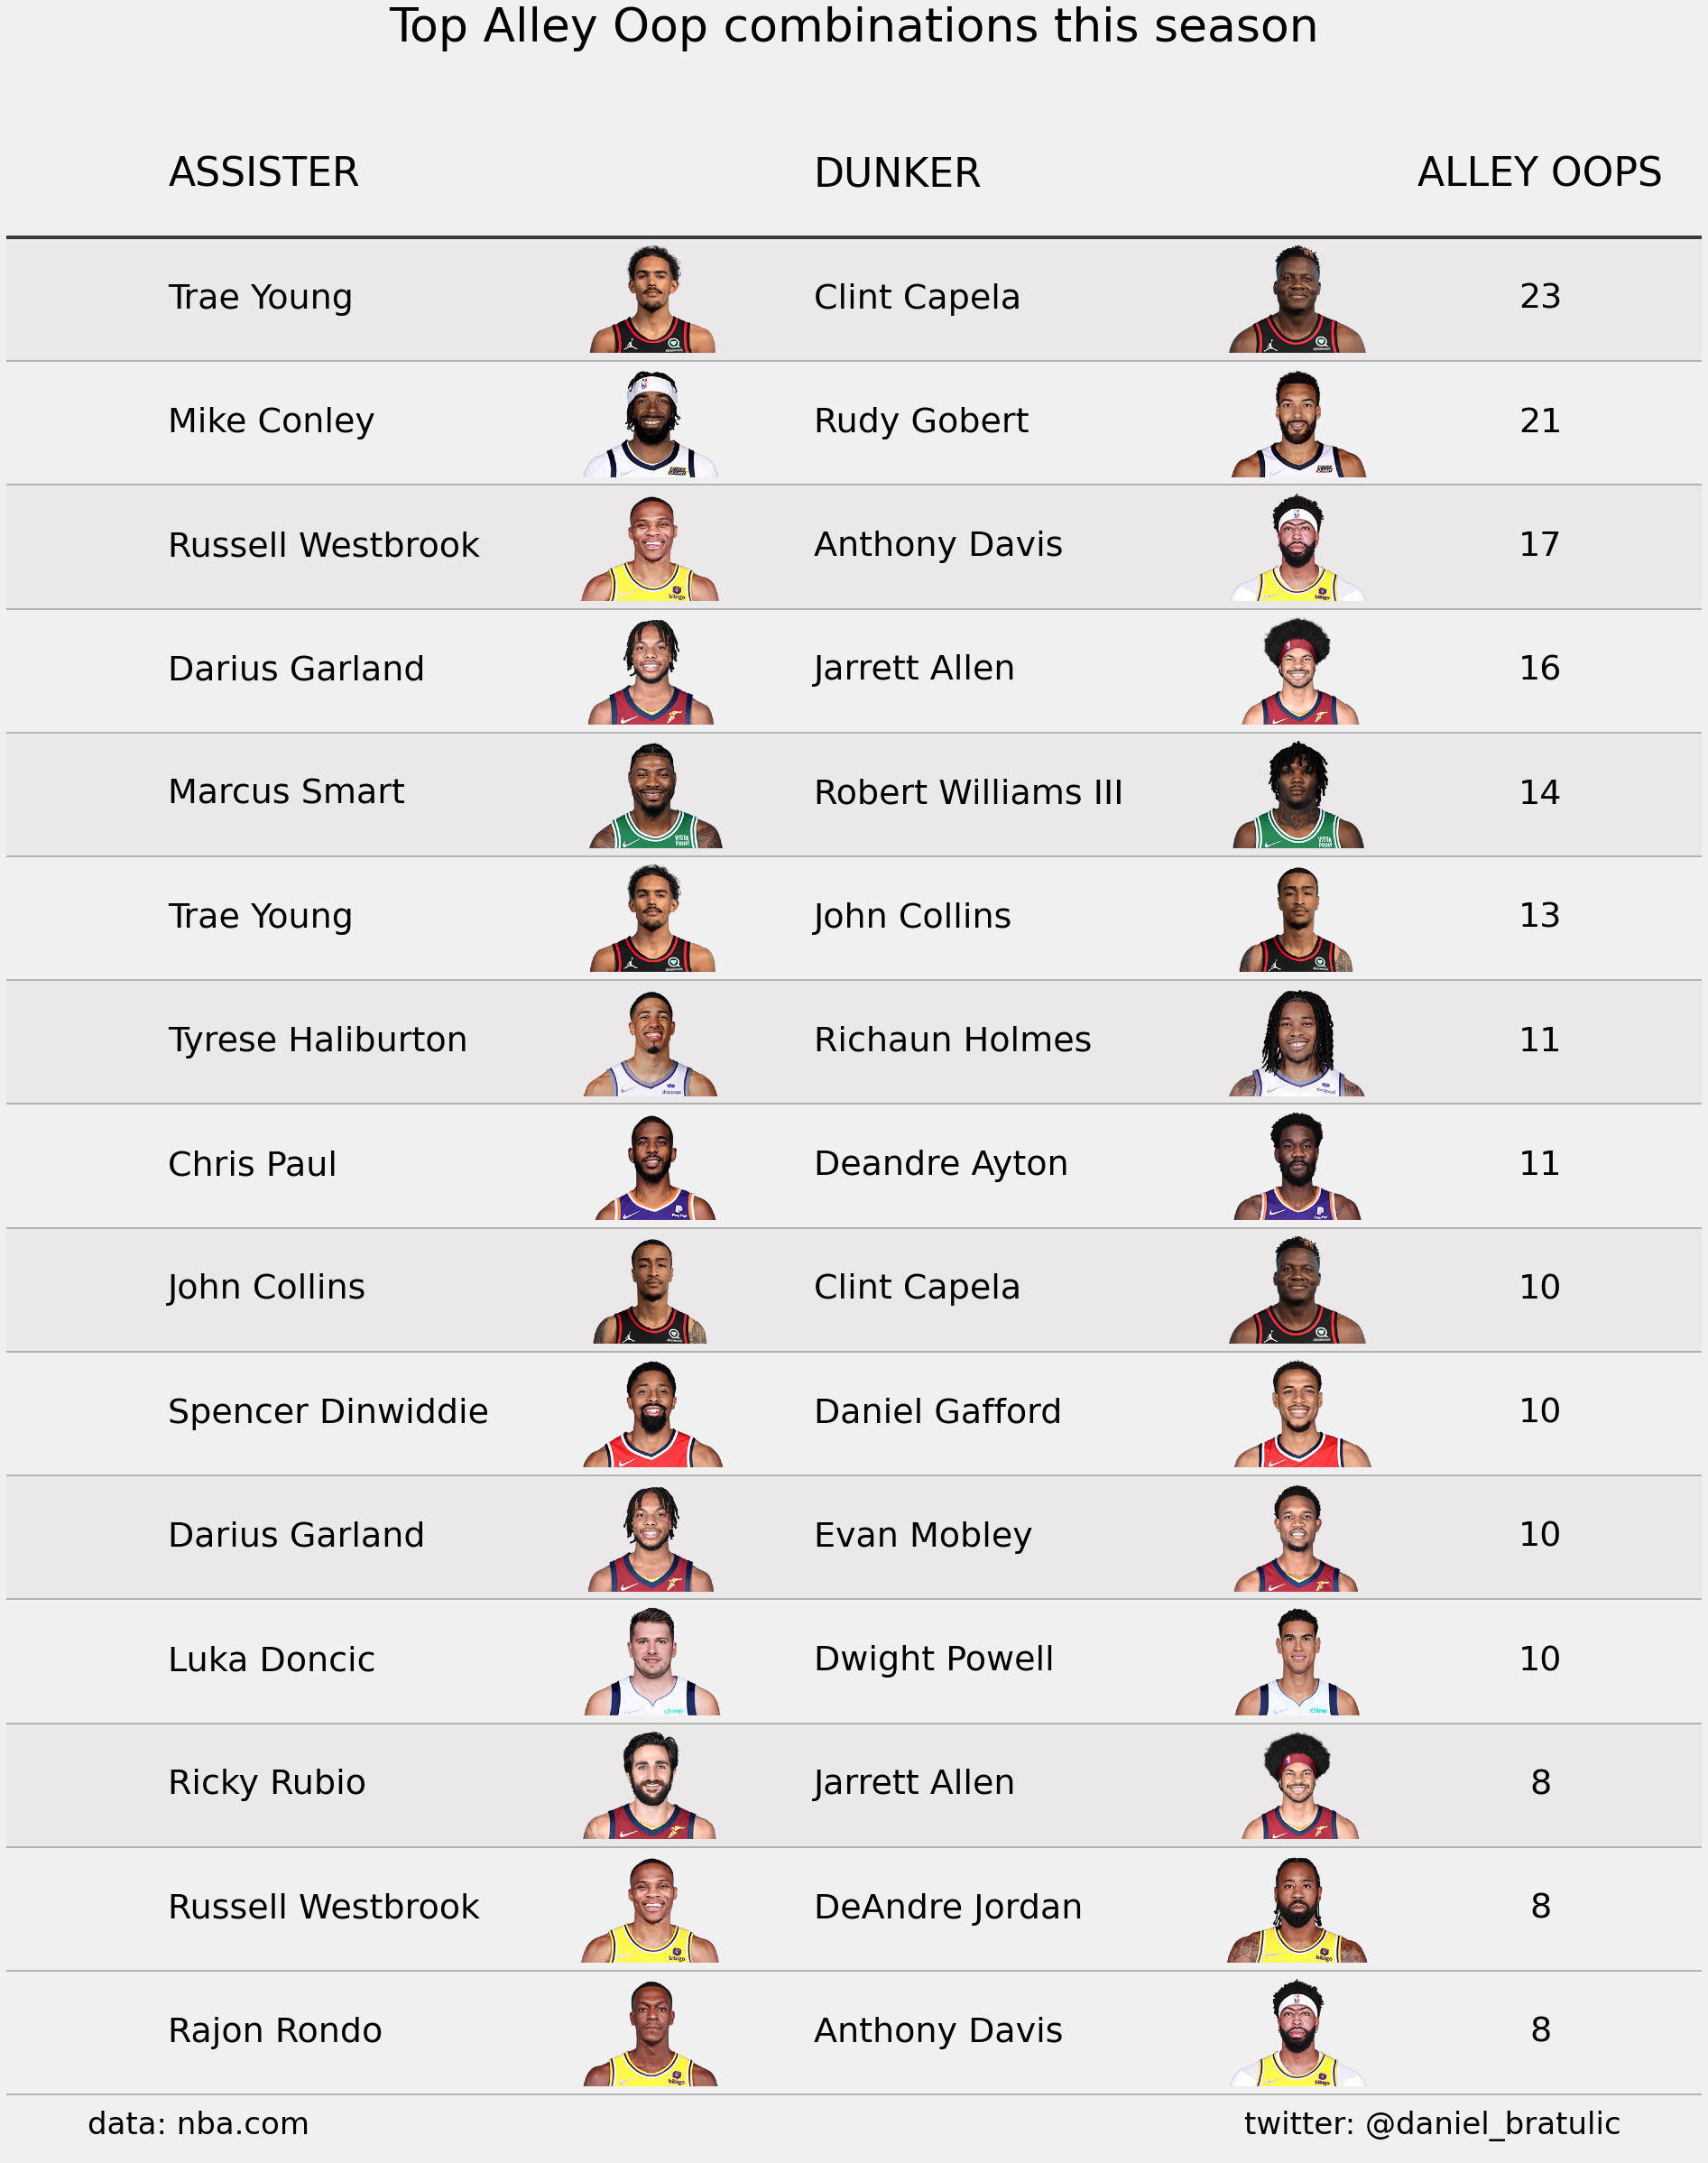

In [68]:
fig, ax = plt.subplots(figsize=(30, 40))
font_size = 38
font_title = 44
top = len(top_alley_oopers)
#top = 10


for i in range(top):
    item = top_alley_oopers.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID), (0.4, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER2_NAME, size=font_size)
    
    ab = AnnotationBbox(get_player_img(item.PLAYER1_ID), (0.8, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER1_NAME, size=font_size)
    ax.text(x=0.95, y=y_coord, ha='center', va='center', s=f"{item.COUNT}", size=font_size)
    #ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.OPP_WIDE_OPEN_FG3_PCT:.2f}%", size=font_size)
    #ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.DIFF:.2f}%", size=font_size)
    

    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_imgs[item.TEAM_ID], extent=(0.27, 0.38, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.1, y=top, s='ASSISTER', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, ha='left', va='center', s="DUNKER", size=font_title)
ax.text(x=0.95, y=top, ha='center', va='center', s="ALLEY OOPS", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="DIFF", size=font_title)

ax.text(x=1.0, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=34)
ax.text(x=0.05, y=-0.75, s='data: nba.com', ha='left', va='center', size=34)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top Alley Oop combinations this season", size=52)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=1.05)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_dunkers.png', dpi=120, bbox_inches='tight')